In [64]:
from argparse import Namespace
from functools import partial
from pathlib import Path
from collections import (
    OrderedDict,Counter
)

# torch
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import default_collate
## other
from torchtext import vocab
try:
    from torchdata import datapipes as dp
    from torchdata.dataloader2 import DataLoader2
except:
    !pip install torchdata
    from torchdata import datapipes as dp
    from torchdata.dataloader2 import DataLoader2

# manipulation
import numpy as np

# visualization
import matplotlib.pyplot as plt

# others
from tqdm import tqdm

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
args = Namespace(
    # data
    data_base_path = "/content/drive/Othercomputers/My PC/drive/data/surnames/",
    dataset = ["train","test","val"],
    
    # vocab
    mask_tkn = "<MASK>",
    ukn_tkn = "<UKN>",
    beg_tkn = "<B>",
    end_tkn = "<E>",
    
    # model
    embedding_size = 100,
    rnn_hidden_state = 64,
    model_base_path = "/content/drive/Othercomputers/My PC/drive/models/seq_model/seq_pred",
    model_filename = "model.pth",
    
    # Training
    num_epochs = 100,
    batch_size = 2,
    learning_rate = 1e-3,
    seed = 1423,
    
    # runtime
    cuda = torch.cuda.is_available(),
    device = "cuda" if torch.cuda.is_available() else "cpu",
)

for k,v in args._get_kwargs():
    if "base" in k:
        Path(v).mkdir(parents=True,exist_ok=True)

# Datapipe

## build pipe dict

In [67]:
def build_pipe_dict(args=args):
    pipe_dict = {}
    for fname in args.dataset:
        pipe_dict[fname] = dp.iter.FileOpener([args.data_base_path+f"{fname}.csv"]).parse_csv()
    return pipe_dict

In [68]:
pipe_dict = build_pipe_dict()
pipe_dict

{'train': CSVParserIterDataPipe,
 'test': CSVParserIterDataPipe,
 'val': CSVParserIterDataPipe}

In [69]:
{k:len(list(pipe)) for k,pipe in pipe_dict.items()}

{'train': 7684, 'test': 1648, 'val': 1648}

In [70]:
{k:next(iter(pipe)) for k,pipe in pipe_dict.items()}

{'train': ['Woodford', 'English'],
 'test': ['Kore', 'English'],
 'val': ['Winship', 'English']}

# build vocab dict

In [71]:
def build_vocab_dict(train_pipe,args=args):
    name_counter = Counter()
    nation_counter = Counter()
    max_seq_length = -1
    for name,nation in train_pipe:
        max_seq_length = max(len(name),max_seq_length)
        name_counter.update(name)
        nation_counter.update([nation])
        
    sort_fn = lambda kf : (-kf[1],kf[0])
    name_sort_tuples = sorted(name_counter.items(),key=sort_fn)
    nation_sort_tuples = sorted(nation_counter.items(),key=sort_fn)
    
    name_vocab = vocab.vocab(ordered_dict=OrderedDict(name_sort_tuples),
                             specials=[args.mask_tkn,
                                       args.ukn_tkn,
                                       args.beg_tkn,
                                       args.end_tkn])
    name_vocab.set_default_index(name_vocab[args.ukn_tkn])
    name_vocab.max_seq_length = max_seq_length + 2
    
    nation_vocab = vocab.vocab(ordered_dict=OrderedDict(nation_sort_tuples))
    freq = [count for _,count in nation_sort_tuples]
    nation_vocab.class_weights = 1.0 / torch.tensor(freq)
    
    return {"char":name_vocab,
            "nation":nation_vocab}

In [72]:
vocab_dict = build_vocab_dict(pipe_dict["train"])
vocab_dict

{'char': Vocab(), 'nation': Vocab()}

In [73]:
{k:len(vocab) for k,vocab in vocab_dict.items()}

{'char': 83, 'nation': 18}

In [74]:
vocab_dict["char"].max_seq_length

19

In [75]:
vocab_dict["nation"].class_weights

tensor([0.0005, 0.0006, 0.0009, 0.0018, 0.0024, 0.0025, 0.0034, 0.0055, 0.0060,
        0.0063, 0.0065, 0.0078, 0.0092, 0.0119, 0.0189, 0.0192, 0.0250, 0.0263])

## build dataset dict

In [76]:
def vectorize(name,char_vocab,args=args):
    indices = [char_vocab[args.beg_tkn]]
    indices.extend(char_vocab.lookup_indices(list(name)))
    indices.append(char_vocab[args.end_tkn])
    
    from_vector = np.full(shape=char_vocab.max_seq_length,
                          fill_value=char_vocab[args.mask_tkn],
                          dtype=np.int64)
    from_indices = indices[:-1]
    from_vector[:len(from_indices)] = from_indices
    
    to_vector = np.full(shape=char_vocab.max_seq_length,
                        fill_value=char_vocab[args.mask_tkn],
                        dtype=np.int64)
    to_indices = indices[1:]
    to_vector[:len(to_indices)] = to_indices
    
    return from_vector,to_vector

In [77]:
vectorize("lak",vocab_dict["char"])

(array([ 2, 11,  4, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]),
 array([11,  4, 15,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]))

In [78]:
def create_dataset(vocab_dict,args,row):
    from_vector , to_vector  = vectorize(row[0],char_vocab=vocab_dict["char"],args=args)
    nation_index = vocab_dict["nation"][row[1]]
    
    return {"x":from_vector,
            "y":to_vector,
            "class_index":nation_index}
    
def collate_fn(args,batch):
    return {k:v.to(args.device)
            for k,v in default_collate(batch).items()}

In [79]:
def build_dataset_dict(pipe_dict,vocab_dict,args=args):
    dataset_dict = {}
    fn = partial(create_dataset,vocab_dict,args)
    for dataset,pipe in pipe_dict.items():
        if dataset == "train":
            pipe = pipe.shuffle()
        
        pipe = pipe.map(fn)
        pipe = pipe.batch(args.batch_size,drop_last=True)
        pipe = pipe.collate(partial(collate_fn,args))
        dataset_dict[dataset] = pipe
    
    return dataset_dict

In [80]:
dataset_dict = build_dataset_dict(pipe_dict,vocab_dict)
dataset_dict

{'train': CollatorIterDataPipe,
 'test': CollatorIterDataPipe,
 'val': CollatorIterDataPipe}

In [81]:
{k:len(list(pipe)) for k,pipe in dataset_dict.items()}

{'train': 3842, 'test': 824, 'val': 824}

# Model

In [82]:
class SurnameGenerativeModel(nn.Module):
    def __init__(self,char_embedding_size,char_vocab_size,
                 rnn_hidden_size,batch_first=True,padding_idx = 0,
                 dropout_rate = 0.5) -> None:
        super().__init__()
        self.char_emb = nn.Embedding(embedding_dim=char_embedding_size,
                                     num_embeddings=char_vocab_size,
                                     padding_idx=padding_idx)
        self.rnn = nn.GRU(input_size = char_embedding_size,
                          hidden_size = rnn_hidden_size,
                          batch_first = batch_first)
        self.fc = nn.Linear(in_features=rnn_hidden_size,
                            out_features=char_vocab_size)
        self.dropout_rate = dropout_rate
        
    def forward(self,input,apply_softmax=False):
        # shape [batch,seq_length]
        x_emb = self.char_emb(input)
        # shape [batch,seq,emb]
        y_out,_ = self.rnn(x_emb)
        # shape [batch,seq,hidden]
        batch_size,seq_size,feat_size = y_out.size()
        
        y_out = y_out.contiguous().view(batch_size*seq_size,feat_size)
        
        y_out = self.fc(F.dropout(y_out,p=self.dropout_rate))
        
        if apply_softmax:
            y_out = F.softmax(y_out,dim=1)
        
        new_feat_size = y_out.shape[-1]
        y_out = y_out.view(batch_size,seq_size,new_feat_size)
        
        return y_out

In [83]:
model = SurnameGenerativeModel(char_embedding_size=args.embedding_size,
                               char_vocab_size=len(vocab_dict["char"]),
                               rnn_hidden_size=args.rnn_hidden_state,
                               padding_idx=vocab_dict["char"][args.mask_tkn]).to(args.device)

In [84]:
pipe_dict = build_pipe_dict()
vocab_dict = build_vocab_dict(pipe_dict["train"])
dataset_dict = build_dataset_dict(pipe_dict,vocab_dict,args)

In [85]:
sample = next(iter(dataset_dict["train"]))
sample

{'x': tensor([[ 2, 24, 17,  5,  9, 13, 20, 12,  5,  8, 15,  6,  0,  0,  0,  0,  0,  0,
           0],
         [ 2, 25, 14, 11, 11,  5,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0]], device='cuda:0'),
 'y': tensor([[24, 17,  5,  9, 13, 20, 12,  5,  8, 15,  6,  3,  0,  0,  0,  0,  0,  0,
           0],
         [25, 14, 11, 11,  5,  8,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0]], device='cuda:0'),
 'class_index': tensor([ 1, 11], device='cuda:0')}

In [86]:
vocab_dict["char"].max_seq_length

19

In [87]:
sample_embed = model.char_emb(sample["x"])
sample_embed.shape

torch.Size([2, 19, 100])

In [88]:
sample_rnn,_ = model.rnn(sample_embed)
sample_rnn.shape

torch.Size([2, 19, 64])

In [89]:
batch_size,seq_size,feat_size = sample_rnn.size()
sample_out = sample_rnn.contiguous().view(batch_size*seq_size,feat_size)
sample_out.shape

torch.Size([38, 64])

In [90]:
len(vocab_dict["char"])

83

In [91]:
sample_fc = model.fc(sample_out)
sample_fc.shape

torch.Size([38, 83])

In [92]:
sample_y_pred = sample_fc.view(batch_size,seq_size,-1)
sample_y_pred.shape

torch.Size([2, 19, 83])

In [93]:
sample_y_pred

tensor([[[ 0.1386,  0.1926, -0.0936,  ...,  0.1602, -0.4090, -0.0446],
         [ 0.2368,  0.2812,  0.0094,  ...,  0.1453, -0.1953,  0.0091],
         [-0.0059,  0.1621,  0.0458,  ...,  0.0992, -0.0612,  0.1376],
         ...,
         [-0.0839,  0.0419,  0.0251,  ..., -0.0167, -0.0507, -0.0319],
         [-0.0917,  0.0408,  0.0231,  ..., -0.0203, -0.0526, -0.0391],
         [-0.0974,  0.0392,  0.0218,  ..., -0.0233, -0.0537, -0.0437]],

        [[ 0.1386,  0.1926, -0.0936,  ...,  0.1602, -0.4090, -0.0446],
         [ 0.2672,  0.1446, -0.2413,  ...,  0.2016, -0.3593, -0.1051],
         [ 0.1246, -0.0154, -0.0037,  ...,  0.1476,  0.0223, -0.2206],
         ...,
         [-0.1071,  0.0332,  0.0197,  ..., -0.0287, -0.0558, -0.0512],
         [-0.1076,  0.0332,  0.0201,  ..., -0.0292, -0.0555, -0.0517],
         [-0.1079,  0.0332,  0.0203,  ..., -0.0296, -0.0553, -0.0519]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [94]:
sample_y_pred.view(-1,sample_y_pred.size(2))

tensor([[ 0.1386,  0.1926, -0.0936,  ...,  0.1602, -0.4090, -0.0446],
        [ 0.2368,  0.2812,  0.0094,  ...,  0.1453, -0.1953,  0.0091],
        [-0.0059,  0.1621,  0.0458,  ...,  0.0992, -0.0612,  0.1376],
        ...,
        [-0.1071,  0.0332,  0.0197,  ..., -0.0287, -0.0558, -0.0512],
        [-0.1076,  0.0332,  0.0201,  ..., -0.0292, -0.0555, -0.0517],
        [-0.1079,  0.0332,  0.0203,  ..., -0.0296, -0.0553, -0.0519]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [95]:
sample["y"]

tensor([[24, 17,  5,  9, 13, 20, 12,  5,  8, 15,  6,  3,  0,  0,  0,  0,  0,  0,
          0],
        [25, 14, 11, 11,  5,  8,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0]], device='cuda:0')

# Loss fn

In [96]:
def normalize_size(y_pred,y_true):
    if len(y_pred.size()) == 3:
        # shape [batch,seq,hidden]
        y_pred = y_pred.contiguous().view(-1,y_pred.size(dim=2))
        # shape [batch*seq,hidden]
    if len(y_true.size()) == 2:
        # shape [batch,seq]
        y_true = y_true.contiguous().view(-1)
        # shape [batch*seq]
    return y_pred,y_true
    
    


def sequence_loss(y_pred,y_true,mask_index):
    y_pred , y_true = normalize_size(y_pred,y_true)
    return F.cross_entropy(input=y_pred, # shape [batch*seq,hidden]
                           target=y_true, # shape [batch*seq]
                           ignore_index=mask_index # this remove value in the target and wont compute loss 
                           )

In [97]:
y_pred = torch.rand(size=(2,7,9))
y_true = torch.randint(low=0,high=7,size=(2,7))

In [98]:
y_true

tensor([[2, 0, 4, 6, 4, 5, 3],
        [4, 0, 2, 5, 5, 4, 0]])

In [99]:
sequence_loss(y_pred,y_true,0)

tensor(2.2264)

In [137]:
def compute_acc(y_pred,y_true,mask_indices):
    y_pred ,y_true = normalize_size(y_pred,y_true)
    
    _,y_pred_indices =y_pred.max(dim=1)
    
    correct_indices = torch.eq(y_pred_indices,y_true).float()
    valid_indices = torch.ne(y_true,mask_indices).float()
    
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()
    
    return n_correct / n_valid

In [138]:
compute_acc(y_pred,y_true,0)

0.0

# Training

## helper function

In [102]:
def make_train_state(args=args):
    return {"stop_early":False,
            "early_stopping_step":0,
            "early_stopping_val":1e5,
            "epoch_index":0,
            "model_filepath":args.model_base_path+args.model_filename,
            "train_loss":[],
            "train_acc":[],
            "val_loss":[],
            "val_acc":[],
            "test_loss":-1,
            "test_acc":-1}

def update_train_state(train_state,model,args=args):
    if train_state["epoch_index"] == 0:
        torch.save(model.state_dict(),train_state["model_filepath"])
        train_state["stop_early"] = False
    
    elif train_state["epoch_index"] >= 1:
        loss_tm1 , loss_t = train_state["val_loss"][-2:]
        if loss_t >= train_state["early_stopping_val"]:
            train_state["early_stopping_step"] +=1
        else:
            torch.save(model.state_dict(),train_state["model_filepath"])
            train_state["early_stopping_step"] = 0
            
        train_state["stop_early"] = train_state["early_stopping_step"] >= args.early_stopping_criteria
    
    return train_state

## Initialize

In [103]:
pipe_dict = build_pipe_dict()
vocab_dict = build_vocab_dict(pipe_dict["train"])
dataset_dict = build_dataset_dict(pipe_dict,vocab_dict,args)

In [104]:
model = SurnameGenerativeModel(char_embedding_size=args.embedding_size,
                               char_vocab_size=len(vocab_dict["char"]),
                               rnn_hidden_size=args.rnn_hidden_state).to(args.device)
optimizer = optim.Adam(params=model.parameters(),
                       lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode="min",factor=0.5,
                                                 patience=1)
train_state = make_train_state(args)
mask_index = vocab_dict["char"][args.mask_tkn]

## Loop

In [105]:
for epoch_index in tqdm(range(args.num_epochs)):
    train_state["epoch_index"] = epoch_index
    
    # get the data
    batch_generator = DataLoader2(datapipe=dataset_dict["train"])
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    
    for batch_idx,batch_dict in enumerate(batch_generator):
        model.zero_grad()
        logits = model(batch_dict["x"])
        
        # loss
        loss = sequence_loss(logits,batch_dict["y"],mask_index)
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) /(batch_idx+1)
        
        # acc
        acc_t = compute_acc(logits,batch_dict["y"],mask_index)
        running_acc += (acc_t - running_acc) / (batch_idx+1)
        
        loss.backward()
        optimizer.step()
        
    train_state["train_loss"].append(running_loss)
    train_state["train_acc"].append(running_acc)
    
    # iterate over the val 
    batch_generator = DataLoader2(dataset_dict["val"])
    running_loss = 0.0
    running_acc = 0.0
    model.eval()
    
    for batch_idx,batch_dict in enumerate(batch_generator):
        with torch.inference_mode():
            logits = model(batch_dict["x"])
            
            # loss
            loss = sequence_loss(logits,batch_dict["y"],mask_index)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) /(batch_idx+1)
            
            # acc
            acc_t = compute_acc(logits,batch_dict["y"],mask_index)
            running_acc += (acc_t - running_acc) / (batch_idx+1)   
            
    train_state["val_loss"].append(running_loss)         
    train_state["val_acc"].append(running_acc)
    
    scheduler.step(train_state["val_loss"][-1])
    
    if train_state["stop_early"]:
        break          

100%|██████████| 100/100 [19:05<00:00, 11.46s/it]


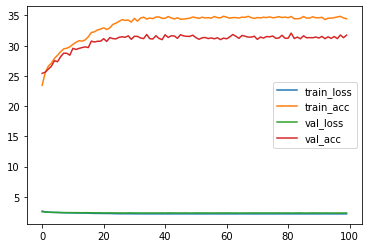

In [106]:
plt.plot(train_state["train_loss"],label="train_loss")
plt.plot(train_state["train_acc"],label="train_acc")
plt.plot(train_state["val_loss"],label="val_loss")
plt.plot(train_state["val_acc"],label="val_acc")
plt.legend();

In [107]:
batch_generator = DataLoader2(dataset_dict["test"])
running_loss = 0.0
running_acc = 0.0
model.eval()

for batch_idx,batch_dict in enumerate(batch_generator):
    with torch.inference_mode():
        logits = model(batch_dict["x"])
        
        # loss
        loss = sequence_loss(logits,batch_dict["y"],mask_index)
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) /(batch_idx+1)
        
        # acc
        acc_t = compute_acc(logits,batch_dict["y"],mask_index)
        running_acc += (acc_t - running_acc) / (batch_idx+1)   
        
train_state["test_loss"] = running_loss
train_state["test_acc"] = running_acc

In [108]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 2.3607683116660563;
Test Accuracy: 31.444514706891574


In [121]:
def sample_from_model(model,char_vocab,num_samples,sample_size=20,args=args):
    # creating the begin index for all samples
    begin_seq_index = [char_vocab[args.beg_tkn]
                       for _ in range(num_samples)]
    # converting and add dim
    begin_seq_index = torch.tensor(begin_seq_index,dtype=torch.int64).unsqueeze(dim=1)
    
    indices = [begin_seq_index]
    h_t = None
    
    for time_step in range(sample_size):
        x_t = indices[time_step]
        # shape [num_sample,1]
        x_emd_t = model.char_emb(x_t)
        # shape [num_sample,1,emb]
        rnn_t,h_t = model.rnn(x_emd_t,h_t)
        # shape rnn_t [num_samples,1,hidden]
        # shape h_t [1,num_samples,hidden]
        pred_vector = model.fc(
            rnn_t.squeeze(dim=1)  # shape [num_sample,hidden]
            )
        # shape [num_sample,char_vocab_size]
        prob_vector = F.softmax(pred_vector,dim=1)
        # shape [num_sample,char_vocab_size]
        select = torch.multinomial(prob_vector,num_samples=1)
        indices.append(select)
    indices = torch.stack(indices)
    indices = indices.squeeze().permute(1,0)
    return indices     

In [122]:
def decode_samples(sampled_indices,char_vocab,args=args):
    decoded_surnames = []
    
    for sample_index in range(sampled_indices.shape[0]):
        surname = ""
        for time_step in range(sampled_indices.shape[1]):
            sample_item = sampled_indices[sample_index,time_step].item()
            if sample_item == char_vocab[args.beg_tkn]:
                continue
            elif sample_item == char_vocab[args.end_tkn]:
                break
            else:
                surname += char_vocab.get_itos()[sample_item]
        decoded_surnames.append(surname)
    return decoded_surnames

In [136]:
num_names = 10
model = model.cpu()
sampled_surnames = decode_samples(sample_from_model(model,vocab_dict["char"],num_samples=num_names),
                                  char_vocab=vocab_dict["char"])
sampled_surnames

['Norle',
 'Pettary',
 'peihurigane',
 'Puskov',
 'Baviston',
 'Tolenteevan',
 'Pabis',
 'Iricharik',
 'Marcon',
 'Lund']